In [596]:
import os
import sys
sys.path = ['/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages'] + sys.path
GTEx_directory = '/hps/nobackup/research/stegle/users/willj/GTEx'
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import numpy as np
from limix.plot import qqplot
import warnings
import h5py
from scipy.stats import pearsonr
import statsmodels.stats.multitest as smm
import gzip
import pandas as pd

mean_features = {}
with h5py.File(GTEx_directory + '/data/intermediate/new_retrained_inceptionet_aggregations.hdf5','r') as f:
    expression = f['lung']['256']['expression'].value
    donor_IDs = f['lung']['256']['donor_IDs'].value
    for s in ['128','256','512','1024','2048']:
        size_mean_features = f['lung'][s]['mean'].value
        mean_features[s] = size_mean_features
        
        
    expression_IDs = f['lung']['256']['expression_IDs'].value

most_expressed_transcript_idx, most_varying_feature_idx, results = pickle.load(open(GTEx_directory + '/data/intermediate/retrained_quick_pvalues.py','rb'))

filt_expression = expression[:,most_expressed_transcript_idx]
filt_features = mean_features['256'][:,most_varying_feature_idx]

phenotype_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/PhenotypeFiles/phs000424.v6.pht002743.v6.p1.c1.GTEx_Sample_Attributes.GRU.txt.gz'
with gzip.open(phenotype_filepath, 'rb') as f:
    phenotype_array = [str(x, 'utf-8').split('\t') for x in f.read().splitlines() if not str(x, 'utf-8').startswith('#')][1:]
    phenotype_df = pd.DataFrame(phenotype_array)
    phenotype_df.columns = phenotype_df.iloc[0]
    phenotype_df = phenotype_df[1:]

lung_df = phenotype_df[phenotype_df['SMTSD'] == 'Lung']
phenotype_idx = [[x.split('-')[1] for x in lung_df['SAMPID']].index(ID) for ID in [x.decode('utf-8').split('-')[1] for x in donor_IDs]]


lung_df = phenotype_df[phenotype_df['SMTSD'] == 'Lung']
lung_df = lung_df.iloc[phenotype_idx,:]

filt_tech_expression =  filt_expression[technical_idx,:]
filt_tech_features =  filt_features[technical_idx,:]
print ("Filtered technical features:")
print (filt_tech_expression.shape, filt_tech_features.shape)

Filtered technical features:
(231, 200) (231, 100)


In [596]:
import os
import sys
sys.path = ['/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages'] + sys.path
GTEx_directory = '/hps/nobackup/research/stegle/users/willj/GTEx'
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import numpy as np
from limix.plot import qqplot
import warnings
import h5py
from scipy.stats import pearsonr
import statsmodels.stats.multitest as smm
import gzip
import pandas as pd

mean_features = {}
with h5py.File(GTEx_directory + '/data/intermediate/new_retrained_inceptionet_aggregations.hdf5','r') as f:
    expression = f['lung']['256']['expression'].value
    donor_IDs = f['lung']['256']['donor_IDs'].value
    for s in ['128','256','512','1024','2048']:
        size_mean_features = f['lung'][s]['mean'].value
        mean_features[s] = size_mean_features
        
        
    expression_IDs = f['lung']['256']['expression_IDs'].value

most_expressed_transcript_idx, most_varying_feature_idx, results = pickle.load(open(GTEx_directory + '/data/intermediate/retrained_quick_pvalues.py','rb'))

filt_expression = expression[:,most_expressed_transcript_idx]
filt_features = mean_features['256'][:,most_varying_feature_idx]

phenotype_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/PhenotypeFiles/phs000424.v6.pht002743.v6.p1.c1.GTEx_Sample_Attributes.GRU.txt.gz'
with gzip.open(phenotype_filepath, 'rb') as f:
    phenotype_array = [str(x, 'utf-8').split('\t') for x in f.read().splitlines() if not str(x, 'utf-8').startswith('#')][1:]
    phenotype_df = pd.DataFrame(phenotype_array)
    phenotype_df.columns = phenotype_df.iloc[0]
    phenotype_df = phenotype_df[1:]

lung_df = phenotype_df[phenotype_df['SMTSD'] == 'Lung']
phenotype_idx = [[x.split('-')[1] for x in lung_df['SAMPID']].index(ID) for ID in [x.decode('utf-8').split('-')[1] for x in donor_IDs]]


lung_df = phenotype_df[phenotype_df['SMTSD'] == 'Lung']
lung_df = lung_df.iloc[phenotype_idx,:]

filt_tech_expression =  filt_expression[technical_idx,:]
filt_tech_features =  filt_features[technical_idx,:]
print ("Filtered technical features:")
print (filt_tech_expression.shape, filt_tech_features.shape)

Filtered technical features:
(231, 200) (231, 100)


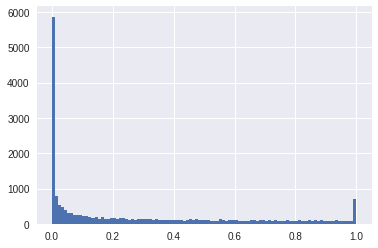

In [780]:
plt.hist(results['mean_256_pvalues'].flatten(),bins=100)
plt.show()

This results in 76 covariates for each of the 274 lung samples.

We define our function to again estimate the inflation parameter, $\lambda$.

In [597]:
import scipy.stats as st
import scipy as sp
def estimate_lambda(pv):
    """estimate lambda form a set of PV"""
    LOD2 = sp.median(st.chi2.isf(pv, 1))
    null_median = st.chi2.median(1)
    L = (LOD2 / null_median)
    return (L)

We take only the samples for which we have technical factors. 

In [598]:
clean_lung_df = pd.DataFrame()
for col in lung_df.columns:
    clean_factor = pd.to_numeric(lung_df[col],errors='coerce')
    clean_lung_df[col] = clean_factor
    

clean_lung_df = clean_lung_df.dropna(how='all',axis=1)
technical_idx = np.array(clean_lung_df.isnull().sum(axis=1) == 0)
clean_lung_df = clean_lung_df.dropna(how='any',axis=0)
raw_technical_covariates = np.array(clean_lung_df)
filter_technical_cov_idx = np.std(raw_technical_covariates,axis=0) < 100
raw_technical_covariates = raw_technical_covariates[:,filter_technical_cov_idx]

This results in a total of 231 samples. We also ensure that we take technical factors with limited variance (< 100), this results in 29 continuous technical factors.

In [599]:
print ("Raw features:")
print (mean_features['256'].shape, expression.shape)
print ("Filtered features:")
print (filt_expression.shape, filt_features.shape)
print ("Technical factors:")
print (raw_technical_covariates.shape)

Raw features:
(274, 1024) (274, 28683)
Filtered features:
(274, 200) (274, 100)
Technical factors:
(231, 29)


Here are the names of the different technical factors we have included. Here are some example descriptions:
* SMATSSCR: Autolysis score
* SMRIN: RNA degradation (RIN) number
* SMTSISCH: Ischemic time

In [578]:
clean_lung_df.columns

Index(['dbGaP_Sample_ID', 'SMATSSCR', 'SMRIN', 'SMUBRID', 'SMTSISCH',
       'SMTSPAX', 'SME2MPRT', 'SMCHMPRS', 'SMNTRART', 'SMNUMGPS', 'SMMAPRT',
       'SMEXNCRT', 'SM550NRM', 'SMGNSDTC', 'SMUNMPRT', 'SM350NRM', 'SMRDLGTH',
       'SMMNCPB', 'SME1MMRT', 'SMSFLGTH', 'SMESTLBS', 'SMMPPD', 'SMNTERRT',
       'SMRRNANM', 'SMRDTTL', 'SMVQCFL', 'SMMNCV', 'SMTRSCPT', 'SMMPPDPR',
       'SMCGLGTH', 'SMGAPPCT', 'SMUNPDRD', 'SMNTRNRT', 'SMMPUNRT', 'SMEXPEFF',
       'SMMPPDUN', 'SME2MMRT', 'SME2ANTI', 'SMALTALG', 'SME2SNSE', 'SMMFLGTH',
       'SME1ANTI', 'SMSPLTRD', 'SMBSMMRT', 'SME1SNSE', 'SME1PCTS', 'SMRRNART',
       'SME1MPRT', 'SMNUM5CD', 'SMDPMPRT', 'SME2PCTS'],
      dtype='object')

This histogram shows the standard deviations of the technical covariates we have chosen to look at. Note that there are technical factors that still vary a great deal.

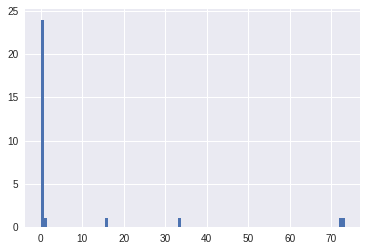

In [580]:
plt.hist(raw_technical_covariates.std(axis=0),bins=100)
plt.show()

Take the first 20 PCs of the expression matrix.

We would like to investigate how including these known technical covariates impact the analysis. 

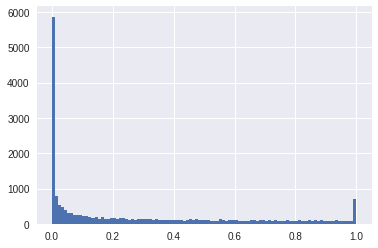

In [780]:
plt.hist(results['mean_256_pvalues'].flatten(),bins=100)
plt.show()

This results in 76 covariates for each of the 274 lung samples.

We define our function to again estimate the inflation parameter, $\lambda$.

In [597]:
import scipy.stats as st
import scipy as sp
def estimate_lambda(pv):
    """estimate lambda form a set of PV"""
    LOD2 = sp.median(st.chi2.isf(pv, 1))
    null_median = st.chi2.median(1)
    L = (LOD2 / null_median)
    return (L)

We take only the samples for which we have technical factors. 

In [598]:
clean_lung_df = pd.DataFrame()
for col in lung_df.columns:
    clean_factor = pd.to_numeric(lung_df[col],errors='coerce')
    clean_lung_df[col] = clean_factor
    

clean_lung_df = clean_lung_df.dropna(how='all',axis=1)
technical_idx = np.array(clean_lung_df.isnull().sum(axis=1) == 0)
clean_lung_df = clean_lung_df.dropna(how='any',axis=0)
raw_technical_covariates = np.array(clean_lung_df)
filter_technical_cov_idx = np.std(raw_technical_covariates,axis=0) < 100
raw_technical_covariates = raw_technical_covariates[:,filter_technical_cov_idx]

This results in a total of 231 samples. We also ensure that we take technical factors with limited variance (< 100), this results in 29 continuous technical factors.

In [599]:
print ("Raw features:")
print (mean_features['256'].shape, expression.shape)
print ("Filtered features:")
print (filt_expression.shape, filt_features.shape)
print ("Technical factors:")
print (raw_technical_covariates.shape)

Raw features:
(274, 1024) (274, 28683)
Filtered features:
(274, 200) (274, 100)
Technical factors:
(231, 29)


Here are the names of the different technical factors we have included. Here are some example descriptions:
* SMATSSCR: Autolysis score
* SMRIN: RNA degradation (RIN) number
* SMTSISCH: Ischemic time

In [578]:
clean_lung_df.columns

Index(['dbGaP_Sample_ID', 'SMATSSCR', 'SMRIN', 'SMUBRID', 'SMTSISCH',
       'SMTSPAX', 'SME2MPRT', 'SMCHMPRS', 'SMNTRART', 'SMNUMGPS', 'SMMAPRT',
       'SMEXNCRT', 'SM550NRM', 'SMGNSDTC', 'SMUNMPRT', 'SM350NRM', 'SMRDLGTH',
       'SMMNCPB', 'SME1MMRT', 'SMSFLGTH', 'SMESTLBS', 'SMMPPD', 'SMNTERRT',
       'SMRRNANM', 'SMRDTTL', 'SMVQCFL', 'SMMNCV', 'SMTRSCPT', 'SMMPPDPR',
       'SMCGLGTH', 'SMGAPPCT', 'SMUNPDRD', 'SMNTRNRT', 'SMMPUNRT', 'SMEXPEFF',
       'SMMPPDUN', 'SME2MMRT', 'SME2ANTI', 'SMALTALG', 'SME2SNSE', 'SMMFLGTH',
       'SME1ANTI', 'SMSPLTRD', 'SMBSMMRT', 'SME1SNSE', 'SME1PCTS', 'SMRRNART',
       'SME1MPRT', 'SMNUM5CD', 'SMDPMPRT', 'SME2PCTS'],
      dtype='object')

This histogram shows the standard deviations of the technical covariates we have chosen to look at. Note that there are technical factors that still vary a great deal.

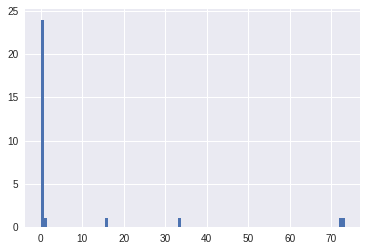

In [580]:
plt.hist(raw_technical_covariates.std(axis=0),bins=100)
plt.show()

Take the first 20 PCs of the expression matrix.

We would like to investigate how including these known technical covariates impact the analysis. 

In [612]:
from sklearn import linear_model
from scipy import stats
import numpy as np
import pdb


class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

    def __init__(self, *args, **kwargs):
        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False
        super(LinearRegression, self).__init__(*args, **kwargs)

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])

        se = np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))
        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self

In [612]:
from sklearn import linear_model
from scipy import stats
import numpy as np
import pdb


class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

    def __init__(self, *args, **kwargs):
        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False
        super(LinearRegression, self).__init__(*args, **kwargs)

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])

        se = np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))
        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self

Compute the first 50 PCs of the expression matrix.

In [613]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca_expression = pca.fit_transform(expression)
filt_pca_expression = pca_expression[technical_idx]

In [841]:
pca_expression.shape

(274, 20)

In [840]:
filt_pca_expression

(231, 20)

In [614]:
X = np.ones(shape=(raw_technical_covariates.shape[0],filt_pca_expression.shape[1] + raw_technical_covariates.shape[1] + 1))
X[:,1:filt_pca_expression.shape[1] + 1] = filt_pca_expression
X[:, 21:] = raw_technical_covariates


Using first 4 PCs, what does the QQ plot look like?

/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


29
1.35447858877


/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


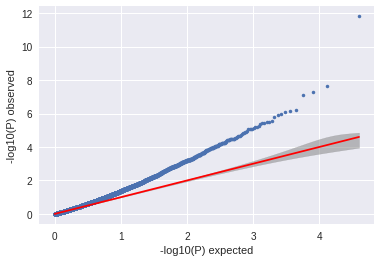

In [792]:
full_pvalues = {}
for f in range(100):
    
    lr = LinearRegression()
    res = lr.fit(X[:,:4],filt_tech_features[:,f])
    eps = res.predict(X[:,:4]) - filt_tech_features[:,f]

    residual_lr = LinearRegression()

    feature_pvalues = []
    for i in range(200):
        pvalue = pearsonr(filt_tech_expression[:,i],eps)[1]
        feature_pvalues.append(pvalue)
    full_pvalues[f] = feature_pvalues

all_pc_full_pvalues = []
for f in range(100):
    all_pc_full_pvalues.extend(full_pvalues[f])
    

print (sum(smm.multipletests(np.array(all_pc_full_pvalues),method='fdr_bh',alpha=0.01)[0]))
print (estimate_lambda(np.array(all_pc_full_pvalues)[np.array(all_pc_full_pvalues) < 1]))
qqplot(np.array(all_pc_full_pvalues))

What do the top associations look like?

In [617]:
def get_t_f_idx(position):
    f = int(np.floor(position / 200))
    t = position % 200
    return f,t

def display_scatter(f,t,axis=None):
    R, pv = pearsonr(filt_features[:,f], filt_expression[:,t])
    if axis:
        axis.scatter(filt_features[:,f], filt_expression[:,t])
        axis.set_title("R: {:0.2} pv: {:0.2}".format(R,pv))
    else:
        plt.scatter(filt_features[:,f], filt_expression[:,t])
    return R, pv

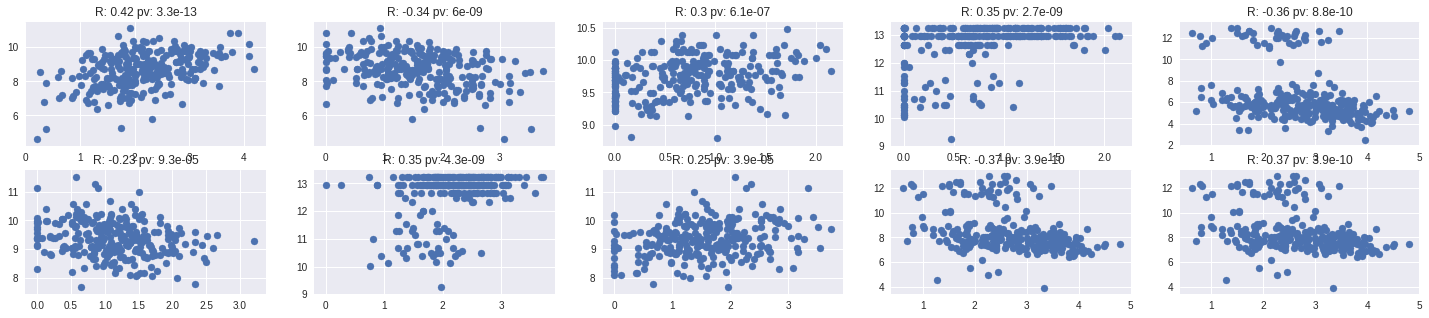

In [618]:
sorted_idx = np.argsort(np.array(all_full_pvalues))
f,a = plt.subplots(2,5,figsize=(25,5))
for i in range(10):
    position = sorted_idx[i]
    f, t = get_t_f_idx(position)
    display_scatter(f,t,a.flatten()[i])

There seems to be signal in the residuals, even when regressing out the effects of the first 9 PCs.

How does the inflation depend on the number of PCs used?

In [619]:
pc_pvalues = {}
pc_lambdas = []
for pc in range(20):
    print (pc)
    feature_pvalues = {}
    for f in range(100):
        
        residual_lr = LinearRegression()
        res = residual_lr.fit(X[:,:pc+1],filt_tech_features[:,f])
        eps = res.predict(X[:,:pc+1]) - filt_tech_features[:,f]
        
        
        pvalues = []
        for i in range(200):
            pvalue = pearsonr(filt_tech_expression[:,i],eps)[1]
            pvalues.append(pvalue)
            
        feature_pvalues[f] = pvalues
        
        

        all_full_pvalues = []
    for f in range(100):
        all_full_pvalues.extend(feature_pvalues[f])

    pc_lambdas.append(estimate_lambda(np.array(all_full_pvalues)))
    pc_pvalues[pc] = all_full_pvalues 

0


/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in absolute
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


1


/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Looking for associations with the residuals after regression out first x PCs

/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


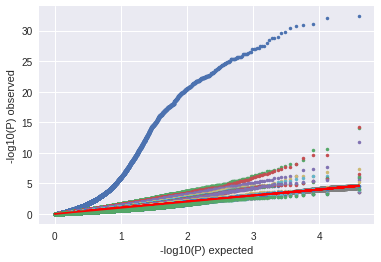

In [620]:
for pc in range(20):
    qqplot(np.array(pc_pvalues[pc]))

QQ plots of association with residuals after regressing a the first for x PCs. x varys from 0 to 28. Each colour represents a different PC.

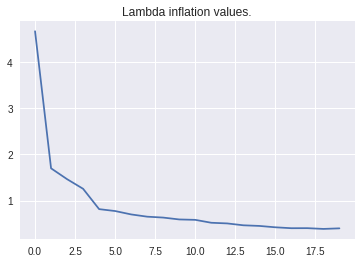

In [622]:
plt.title("Lambda inflation values.")
plt.plot(pc_lambdas)

Lambda as a function of number of PCs used.

# We can repeat this, but instead look at the technical factors.

/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: inval

52
1.63274481423


/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


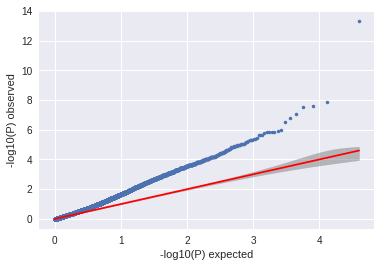

In [689]:
full_pvalues = {}
for f in range(100):    
    lr = LinearRegression()
    res = lr.fit(X[:,21:],filt_tech_features[:,f])
    eps = res.predict(X[:,21:]) - filt_tech_features[:,f]

    feature_pvalues = []
    for i in range(200):
        pvalue = pearsonr(filt_tech_expression[:,i],eps)[1]
        feature_pvalues.append(pvalue)
    full_pvalues[f] = feature_pvalues

all_tech_full_pvalues = []
for f in range(100):
    all_tech_full_pvalues.extend(full_pvalues[f])

print (sum(smm.multipletests(np.array(all_tech_full_pvalues),method='fdr_bh',alpha=0.01)[0]))
print (estimate_lambda(np.array(all_tech_full_pvalues)))
qqplot(np.array(all_tech_full_pvalues))

What do the top associations look like?

48 121
50 115
27 121
10 121
75 121
88 73
59 121
6 121
88 49
81 121


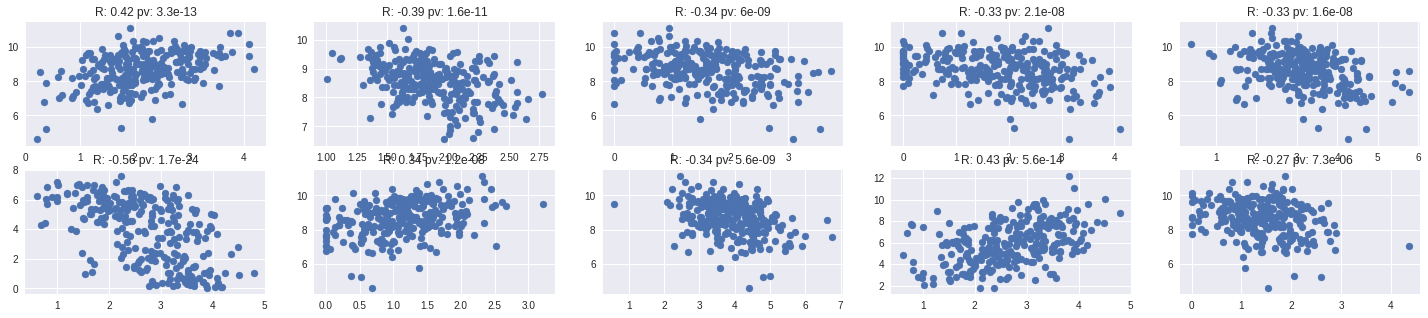

In [626]:
sorted_idx = np.argsort(np.array(all_full_pvalues))
fig,axis = plt.subplots(2,5,figsize=(25,5))
for i in range(10):
    position = sorted_idx[i]
    f, t = get_t_f_idx(position)
    print (f,t)
    display_scatter(f,t,axis.flatten()[i])

# Using first 3 PCs and technical factors as covariates

In [839]:
X.shape

(231, 50)

0


/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: inval

52
1.76522332788
1


/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


8
1.16411767902
2
7
1.06508511475
3
2
0.909999049458
4
1
0.650891252846
5
0
0.598463989663


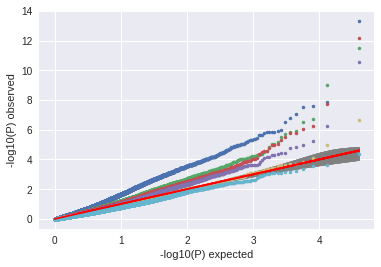

In [793]:
lambdas = []
for pc in range(6):
    print(pc)
    full_pvalues = {}
    for f in range(100):    
        lr = LinearRegression()
        res = lr.fit(np.hstack([X[:,:pc+1], X[:,21:]]),filt_tech_features[:,f])
        eps = res.predict(np.hstack([X[:,:pc+1], X[:,21:]])) - filt_tech_features[:,f]

        feature_pvalues = []
        for i in range(200):
            pvalue = pearsonr(filt_tech_expression[:,i],eps)[1]
            feature_pvalues.append(pvalue)
        full_pvalues[f] = feature_pvalues

    all_tech_and_pc_full_pvalues = []
    for f in range(100):
        all_tech_and_pc_full_pvalues.extend(full_pvalues[f])

    print (sum(smm.multipletests(np.array(all_tech_and_pc_full_pvalues),method='fdr_bh',alpha=0.01)[0]))
    lamb = estimate_lambda(np.array(all_tech_and_pc_full_pvalues)[np.array(all_tech_and_pc_full_pvalues) < 1])
    print (lamb)
    lambdas.append(lamb)
    qqplot(np.array(all_tech_and_pc_full_pvalues))

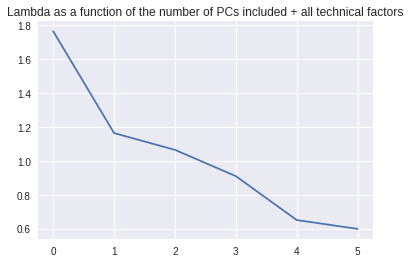

In [797]:
plt.title('Lambda as a function of the number of PCs included + all technical factors')
plt.plot(lambdas)

Using 2 PCs

/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: inval

7
0.984216778659


/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


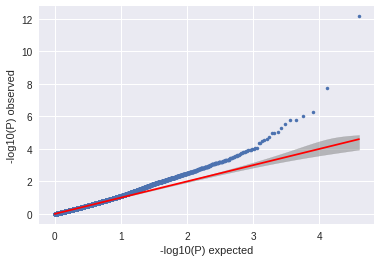

In [794]:

full_pvalues = {}
for f in range(100):    
    lr = LinearRegression()
    res = lr.fit(np.hstack([X[:,:3], X[:,21:]]),filt_tech_features[:,f])
    eps = res.predict(np.hstack([X[:,:3], X[:,21:]])) - filt_tech_features[:,f]

    feature_pvalues = []
    for i in range(200):
        pvalue = pearsonr(filt_tech_expression[:,i],eps)[1]
        feature_pvalues.append(pvalue)
    full_pvalues[f] = feature_pvalues

all_tech_and_pc_full_pvalues = []
for f in range(100):
    all_tech_and_pc_full_pvalues.extend(full_pvalues[f])

print (sum(smm.multipletests(np.array(all_tech_and_pc_full_pvalues),method='fdr_bh',alpha=0.01)[0]))
print (estimate_lambda(np.array(all_tech_and_pc_full_pvalues)))
qqplot(np.array(all_tech_and_pc_full_pvalues))

In [798]:
estimate_lambda(np.array(all_tech_and_pc_full_pvalues)[np.array(all_tech_and_pc_full_pvalues) < 1])

1.0650851147493965

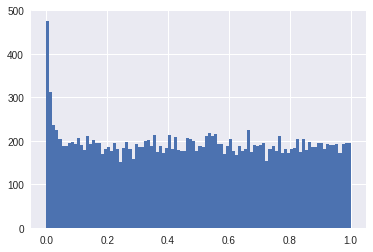

In [801]:
plt.hist(np.array(all_tech_and_pc_full_pvalues)[np.array(all_tech_and_pc_full_pvalues) < 1],bins=100)
plt.show()

In [731]:
from pyensembl import EnsemblRelease

import pdb
data = EnsemblRelease(77)

def get_gene_name(transcript):
    transcript_id = transcript.decode('utf-8').split('.')[0]
    return data.gene_name_of_gene_id(transcript_id)


In [ ]:
most_expressed_transcript_idx][t]

48 121
10 121
50 115
27 121
13 121
57 121
84 121
75 121
20 121
50 128


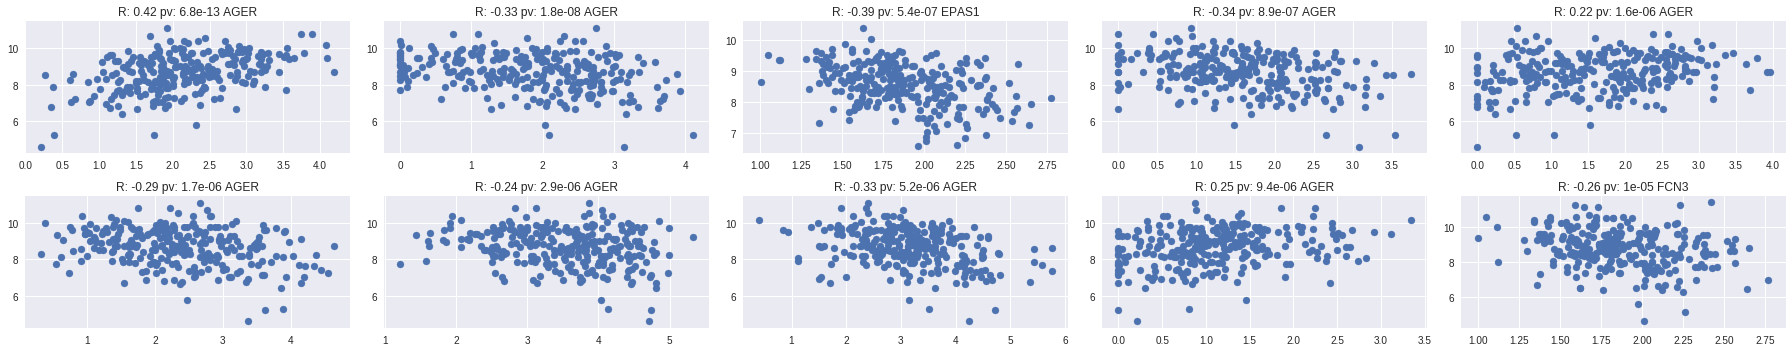

In [800]:
sorted_idx = np.argsort(np.array(all_tech_and_pc_full_pvalues))
fig,axis = plt.subplots(2,5,figsize=(25,5))
for i in range(10):
    position = sorted_idx[i]
    f, t = get_t_f_idx(position)
    print (f,t)
    axis.flatten()[i].scatter(filt_features[:,f], filt_expression[:,t])
    pv = np.array(all_tech_and_pc_full_pvalues)[sorted_idx][i]
    R = pearsonr(filt_features[:,f], filt_expression[:,t])[0]
    transcript_name = get_gene_name(expression_IDs[most_expressed_transcript_idx][t])
    axis.flatten()[i].set_title("R: {:0.2} pv: {:0.2} {}".format(R,pv,transcript_name))
plt.tight_layout()

Compute the first 50 PCs of the expression matrix.

In [613]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca_expression = pca.fit_transform(expression)
filt_pca_expression = pca_expression[technical_idx]

In [841]:
pca_expression.shape

(274, 20)

In [840]:
filt_pca_expression

(231, 20)

In [614]:
X = np.ones(shape=(raw_technical_covariates.shape[0],filt_pca_expression.shape[1] + raw_technical_covariates.shape[1] + 1))
X[:,1:filt_pca_expression.shape[1] + 1] = filt_pca_expression
X[:, 21:] = raw_technical_covariates


Using first 4 PCs, what does the QQ plot look like?

/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


29
1.35447858877


/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


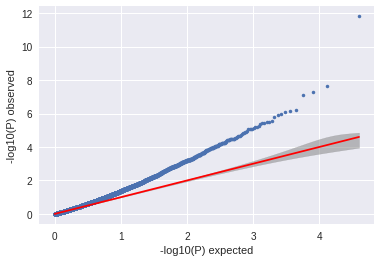

In [792]:
full_pvalues = {}
for f in range(100):
    
    lr = LinearRegression()
    res = lr.fit(X[:,:4],filt_tech_features[:,f])
    eps = res.predict(X[:,:4]) - filt_tech_features[:,f]

    residual_lr = LinearRegression()

    feature_pvalues = []
    for i in range(200):
        pvalue = pearsonr(filt_tech_expression[:,i],eps)[1]
        feature_pvalues.append(pvalue)
    full_pvalues[f] = feature_pvalues

all_pc_full_pvalues = []
for f in range(100):
    all_pc_full_pvalues.extend(full_pvalues[f])
    

print (sum(smm.multipletests(np.array(all_pc_full_pvalues),method='fdr_bh',alpha=0.01)[0]))
print (estimate_lambda(np.array(all_pc_full_pvalues)[np.array(all_pc_full_pvalues) < 1]))
qqplot(np.array(all_pc_full_pvalues))

What do the top associations look like?

In [617]:
def get_t_f_idx(position):
    f = int(np.floor(position / 200))
    t = position % 200
    return f,t

def display_scatter(f,t,axis=None):
    R, pv = pearsonr(filt_features[:,f], filt_expression[:,t])
    if axis:
        axis.scatter(filt_features[:,f], filt_expression[:,t])
        axis.set_title("R: {:0.2} pv: {:0.2}".format(R,pv))
    else:
        plt.scatter(filt_features[:,f], filt_expression[:,t])
    return R, pv

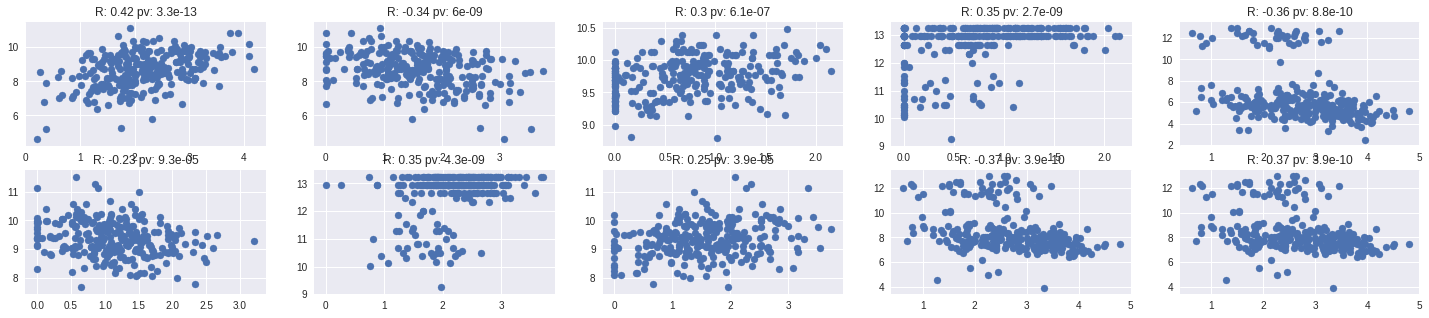

In [618]:
sorted_idx = np.argsort(np.array(all_full_pvalues))
f,a = plt.subplots(2,5,figsize=(25,5))
for i in range(10):
    position = sorted_idx[i]
    f, t = get_t_f_idx(position)
    display_scatter(f,t,a.flatten()[i])

There seems to be signal in the residuals, even when regressing out the effects of the first 9 PCs.

How does the inflation depend on the number of PCs used?

In [619]:
pc_pvalues = {}
pc_lambdas = []
for pc in range(20):
    print (pc)
    feature_pvalues = {}
    for f in range(100):
        
        residual_lr = LinearRegression()
        res = residual_lr.fit(X[:,:pc+1],filt_tech_features[:,f])
        eps = res.predict(X[:,:pc+1]) - filt_tech_features[:,f]
        
        
        pvalues = []
        for i in range(200):
            pvalue = pearsonr(filt_tech_expression[:,i],eps)[1]
            pvalues.append(pvalue)
            
        feature_pvalues[f] = pvalues
        
        

        all_full_pvalues = []
    for f in range(100):
        all_full_pvalues.extend(feature_pvalues[f])

    pc_lambdas.append(estimate_lambda(np.array(all_full_pvalues)))
    pc_pvalues[pc] = all_full_pvalues 

0


/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in absolute
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


1


/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Looking for associations with the residuals after regression out first x PCs

/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


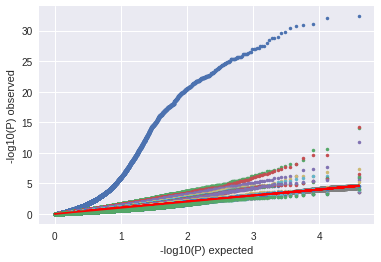

In [620]:
for pc in range(20):
    qqplot(np.array(pc_pvalues[pc]))

QQ plots of association with residuals after regressing a the first for x PCs. x varys from 0 to 28. Each colour represents a different PC.

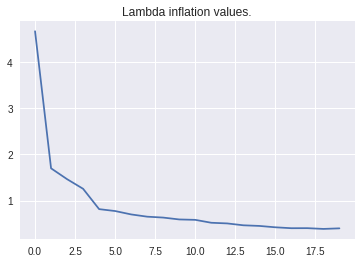

In [622]:
plt.title("Lambda inflation values.")
plt.plot(pc_lambdas)

Lambda as a function of number of PCs used.

# We can repeat this, but instead look at the technical factors.

/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: inval

52
1.63274481423


/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


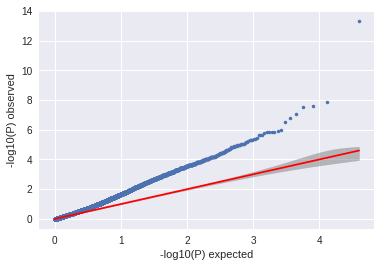

In [689]:
full_pvalues = {}
for f in range(100):    
    lr = LinearRegression()
    res = lr.fit(X[:,21:],filt_tech_features[:,f])
    eps = res.predict(X[:,21:]) - filt_tech_features[:,f]

    feature_pvalues = []
    for i in range(200):
        pvalue = pearsonr(filt_tech_expression[:,i],eps)[1]
        feature_pvalues.append(pvalue)
    full_pvalues[f] = feature_pvalues

all_tech_full_pvalues = []
for f in range(100):
    all_tech_full_pvalues.extend(full_pvalues[f])

print (sum(smm.multipletests(np.array(all_tech_full_pvalues),method='fdr_bh',alpha=0.01)[0]))
print (estimate_lambda(np.array(all_tech_full_pvalues)))
qqplot(np.array(all_tech_full_pvalues))

What do the top associations look like?

48 121
50 115
27 121
10 121
75 121
88 73
59 121
6 121
88 49
81 121


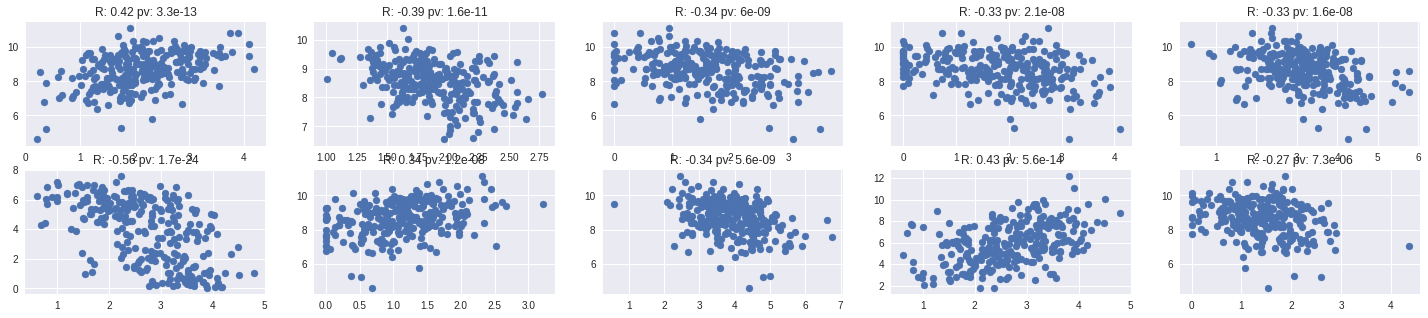

In [626]:
sorted_idx = np.argsort(np.array(all_full_pvalues))
fig,axis = plt.subplots(2,5,figsize=(25,5))
for i in range(10):
    position = sorted_idx[i]
    f, t = get_t_f_idx(position)
    print (f,t)
    display_scatter(f,t,axis.flatten()[i])

# Using first 3 PCs and technical factors as covariates

In [839]:
X.shape

(231, 50)

0


/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: inval

52
1.76522332788
1


/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


8
1.16411767902
2
7
1.06508511475
3
2
0.909999049458
4
1
0.650891252846
5
0
0.598463989663


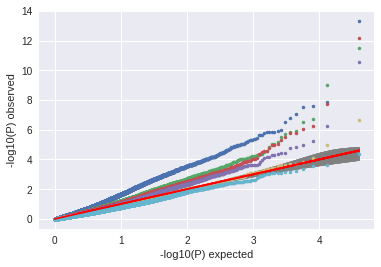

In [793]:
lambdas = []
for pc in range(6):
    print(pc)
    full_pvalues = {}
    for f in range(100):    
        lr = LinearRegression()
        res = lr.fit(np.hstack([X[:,:pc+1], X[:,21:]]),filt_tech_features[:,f])
        eps = res.predict(np.hstack([X[:,:pc+1], X[:,21:]])) - filt_tech_features[:,f]

        feature_pvalues = []
        for i in range(200):
            pvalue = pearsonr(filt_tech_expression[:,i],eps)[1]
            feature_pvalues.append(pvalue)
        full_pvalues[f] = feature_pvalues

    all_tech_and_pc_full_pvalues = []
    for f in range(100):
        all_tech_and_pc_full_pvalues.extend(full_pvalues[f])

    print (sum(smm.multipletests(np.array(all_tech_and_pc_full_pvalues),method='fdr_bh',alpha=0.01)[0]))
    lamb = estimate_lambda(np.array(all_tech_and_pc_full_pvalues)[np.array(all_tech_and_pc_full_pvalues) < 1])
    print (lamb)
    lambdas.append(lamb)
    qqplot(np.array(all_tech_and_pc_full_pvalues))

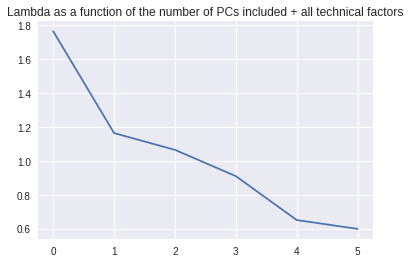

In [797]:
plt.title('Lambda as a function of the number of PCs included + all technical factors')
plt.plot(lambdas)

Using 2 PCs

/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: inval

7
0.984216778659


/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


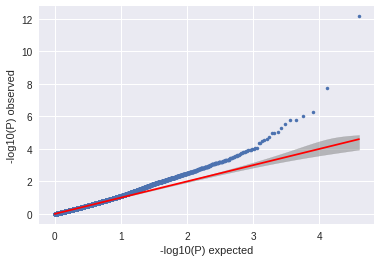

In [794]:

full_pvalues = {}
for f in range(100):    
    lr = LinearRegression()
    res = lr.fit(np.hstack([X[:,:3], X[:,21:]]),filt_tech_features[:,f])
    eps = res.predict(np.hstack([X[:,:3], X[:,21:]])) - filt_tech_features[:,f]

    feature_pvalues = []
    for i in range(200):
        pvalue = pearsonr(filt_tech_expression[:,i],eps)[1]
        feature_pvalues.append(pvalue)
    full_pvalues[f] = feature_pvalues

all_tech_and_pc_full_pvalues = []
for f in range(100):
    all_tech_and_pc_full_pvalues.extend(full_pvalues[f])

print (sum(smm.multipletests(np.array(all_tech_and_pc_full_pvalues),method='fdr_bh',alpha=0.01)[0]))
print (estimate_lambda(np.array(all_tech_and_pc_full_pvalues)))
qqplot(np.array(all_tech_and_pc_full_pvalues))

In [798]:
estimate_lambda(np.array(all_tech_and_pc_full_pvalues)[np.array(all_tech_and_pc_full_pvalues) < 1])

1.0650851147493965

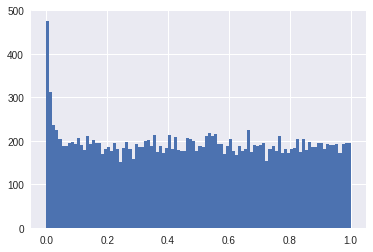

In [801]:
plt.hist(np.array(all_tech_and_pc_full_pvalues)[np.array(all_tech_and_pc_full_pvalues) < 1],bins=100)
plt.show()

In [731]:
from pyensembl import EnsemblRelease

import pdb
data = EnsemblRelease(77)

def get_gene_name(transcript):
    transcript_id = transcript.decode('utf-8').split('.')[0]
    return data.gene_name_of_gene_id(transcript_id)


In [ ]:
most_expressed_transcript_idx][t]

48 121
10 121
50 115
27 121
13 121
57 121
84 121
75 121
20 121
50 128


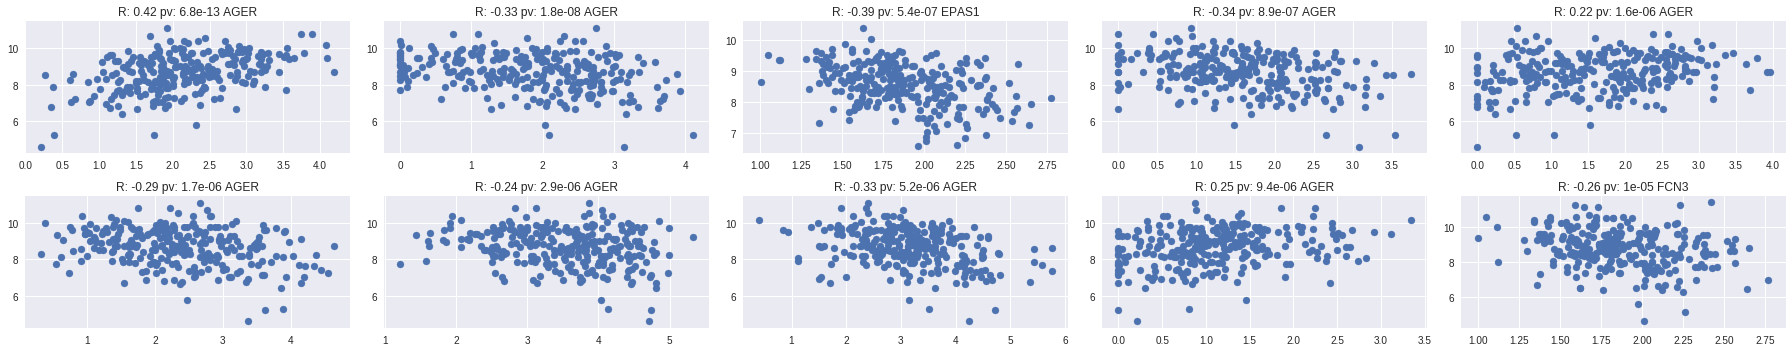

In [800]:
sorted_idx = np.argsort(np.array(all_tech_and_pc_full_pvalues))
fig,axis = plt.subplots(2,5,figsize=(25,5))
for i in range(10):
    position = sorted_idx[i]
    f, t = get_t_f_idx(position)
    print (f,t)
    axis.flatten()[i].scatter(filt_features[:,f], filt_expression[:,t])
    pv = np.array(all_tech_and_pc_full_pvalues)[sorted_idx][i]
    R = pearsonr(filt_features[:,f], filt_expression[:,t])[0]
    transcript_name = get_gene_name(expression_IDs[most_expressed_transcript_idx][t])
    axis.flatten()[i].set_title("R: {:0.2} pv: {:0.2} {}".format(R,pv,transcript_name))
plt.tight_layout()